In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Predictions from Both Models

In [19]:
# Load predictions
season_pred = pd.read_csv('season_predictions.csv')
similarity_pred = pd.read_csv('similarity_predictions.csv')

print(f"Season predictions shape: {season_pred.shape}")
print(f"Similarity predictions shape: {similarity_pred.shape}")

# Verify IDs match
assert (season_pred['ID'] == similarity_pred['ID']).all(), "IDs don't match!"
print("✓ IDs match correctly")

# Display predictions
comparison_df = pd.DataFrame({
    'ID': season_pred['ID'],
    'Season_Pred': season_pred['Production'],
    'Similarity_Pred': similarity_pred['Production']
})

print("\nPredictions comparison:")
comparison_df.head(10)

Season predictions shape: (2250, 2)
Similarity predictions shape: (2250, 2)
✓ IDs match correctly

Predictions comparison:


,ID,Season_Pred,Similarity_Pred
0,90,5348.073672,15140.000000
1,16,13235.378818,9769.734532
2,65,19699.748843,43116.696429
3,138,2613.682057,17687.842478
4,166,3078.679484,6868.551448
5,252,48242.170444,50455.118939
6,234,33316.263330,22249.817944
7,306,31537.290565,40482.756997
8,274,107245.994134,84089.273742
9,268,1042.052956,29163.758499


## 2. Load Training Data for Cross-Validation

In [11]:
# We need to run both models on training data to find optimal weights
# For simplicity, we'll test different weight combinations

print("Note: To find optimal weights, we would need validation predictions from both models.")
print("For now, we'll test different weight combinations and you can adjust based on your validation results.")

Note: To find optimal weights, we would need validation predictions from both models.
For now, we'll test different weight combinations and you can adjust based on your validation results.


## 3. Test Different Weight Combinations

In [12]:
# Define weight combinations to test
weight_combinations = [
    (0.0, 1.0),  # 100% Similarity
    (0.2, 0.8),  # 20% Season, 80% Similarity
    (0.3, 0.7),  # 30% Season, 70% Similarity
    (0.4, 0.6),  # 40% Season, 60% Similarity
    (0.5, 0.5),  # Equal weights
    (0.6, 0.4),  # 60% Season, 40% Similarity
    (0.7, 0.3),  # 70% Season, 30% Similarity
    (0.8, 0.2),  # 80% Season, 20% Similarity
    (1.0, 0.0),  # 100% Season
]

print("Testing different weight combinations:")
print("(These are just examples - optimal weights should be determined using validation data)\n")

for w_season, w_similarity in weight_combinations:
    ensemble_pred = w_season * season_pred['Production'] + w_similarity * similarity_pred['Production']
    print(f"Season: {w_season:.1f}, Similarity: {w_similarity:.1f} | "
          f"Mean: {ensemble_pred.mean():.2f}, Std: {ensemble_pred.std():.2f}")

Testing different weight combinations:
(These are just examples - optimal weights should be determined using validation data)

Season: 0.0, Similarity: 1.0 | Mean: 29672.92, Std: 32656.61
Season: 0.2, Similarity: 0.8 | Mean: 29110.71, Std: 29348.81
Season: 0.3, Similarity: 0.7 | Mean: 28829.60, Std: 28139.56
Season: 0.4, Similarity: 0.6 | Mean: 28548.49, Std: 27282.60
Season: 0.5, Similarity: 0.5 | Mean: 28267.39, Std: 26811.70
Season: 0.6, Similarity: 0.4 | Mean: 27986.28, Std: 26747.28
Season: 0.7, Similarity: 0.3 | Mean: 27705.17, Std: 27092.23
Season: 0.8, Similarity: 0.2 | Mean: 27424.07, Std: 27831.34
Season: 1.0, Similarity: 0.0 | Mean: 26861.85, Std: 30361.81


## 4. Create Ensemble with Recommended Weights

Based on typical ensemble performance, we'll start with **equal weights (0.5, 0.5)** as it often provides good baseline performance. You should adjust these weights based on your validation results from the individual models.

In [13]:
# Recommended starting weights (adjust based on validation performance)
WEIGHT_SEASON = 0.5
WEIGHT_SIMILARITY = 0.5

print(f"Using weights: Season={WEIGHT_SEASON}, Similarity={WEIGHT_SIMILARITY}")
print("(Adjust these based on validation MAE from each model)\n")

# Create ensemble predictions
ensemble_predictions = (
    WEIGHT_SEASON * season_pred['Production'] + 
    WEIGHT_SIMILARITY * similarity_pred['Production']
)

# Ensure predictions are positive
ensemble_predictions = ensemble_predictions.clip(lower=0)

print(f"Ensemble predictions stats:")
print(f"  Mean: {ensemble_predictions.mean():.2f}")
print(f"  Median: {ensemble_predictions.median():.2f}")
print(f"  Std: {ensemble_predictions.std():.2f}")
print(f"  Min: {ensemble_predictions.min():.2f}")
print(f"  Max: {ensemble_predictions.max():.2f}")

Using weights: Season=0.5, Similarity=0.5
(Adjust these based on validation MAE from each model)

Ensemble predictions stats:
  Mean: 28267.39
  Median: 21363.48
  Std: 26811.70
  Min: 899.78
  Max: 298993.79


## 5. Visualize Prediction Distributions

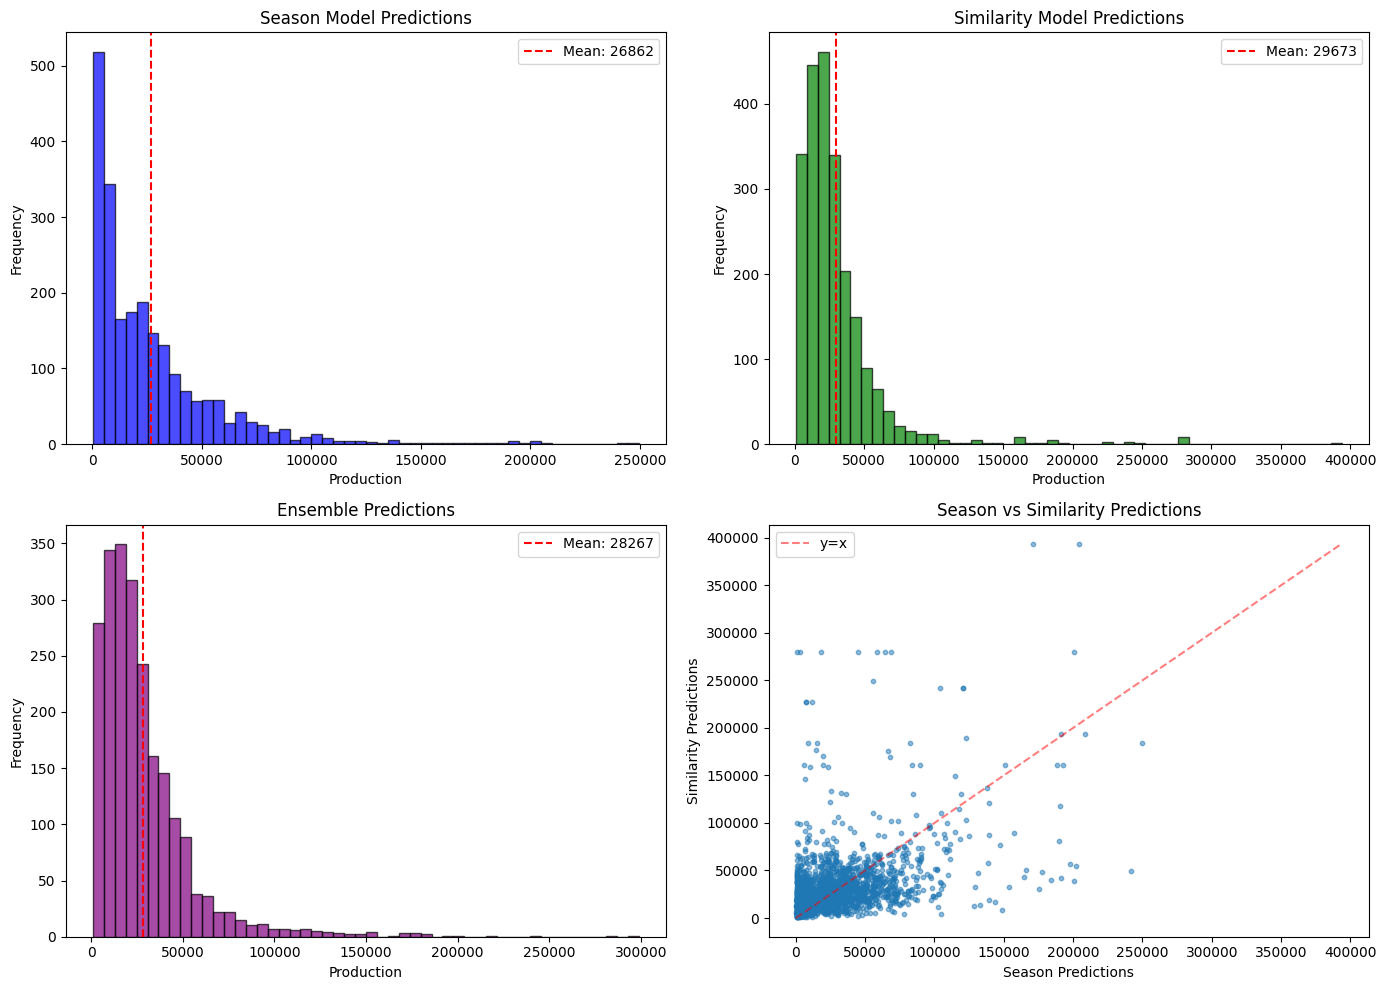

In [14]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Season predictions
axes[0, 0].hist(season_pred['Production'], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_title('Season Model Predictions')
axes[0, 0].set_xlabel('Production')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(season_pred['Production'].mean(), color='red', linestyle='--', label=f'Mean: {season_pred["Production"].mean():.0f}')
axes[0, 0].legend()

# Similarity predictions
axes[0, 1].hist(similarity_pred['Production'], bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title('Similarity Model Predictions')
axes[0, 1].set_xlabel('Production')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(similarity_pred['Production'].mean(), color='red', linestyle='--', label=f'Mean: {similarity_pred["Production"].mean():.0f}')
axes[0, 1].legend()

# Ensemble predictions
axes[1, 0].hist(ensemble_predictions, bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[1, 0].set_title('Ensemble Predictions')
axes[1, 0].set_xlabel('Production')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(ensemble_predictions.mean(), color='red', linestyle='--', label=f'Mean: {ensemble_predictions.mean():.0f}')
axes[1, 0].legend()

# Scatter: Season vs Similarity
axes[1, 1].scatter(season_pred['Production'], similarity_pred['Production'], alpha=0.5, s=10)
axes[1, 1].set_xlabel('Season Predictions')
axes[1, 1].set_ylabel('Similarity Predictions')
axes[1, 1].set_title('Season vs Similarity Predictions')
axes[1, 1].plot([0, max(season_pred['Production'].max(), similarity_pred['Production'].max())], 
                [0, max(season_pred['Production'].max(), similarity_pred['Production'].max())], 
                'r--', alpha=0.5, label='y=x')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 6. Create Final Submission File

In [15]:
# Create final submission
final_submission = pd.DataFrame({
    'ID': season_pred['ID'],
    'Production': ensemble_predictions
})

# Round to reasonable precision
final_submission['Production'] = final_submission['Production'].round(2)

# Save submission
final_submission.to_csv('submission_ensemble.csv', index=False)
print("✓ Final ensemble submission saved to 'submission_ensemble.csv'")

print("\nFirst 10 predictions:")
final_submission.head(10)

✓ Final ensemble submission saved to 'submission_ensemble.csv'

First 10 predictions:


,ID,Production
0,90,10244.04
1,16,11502.56
2,65,31408.22
3,138,10150.76
4,166,4973.62
5,252,49348.64
6,234,27783.04
7,306,36010.02
8,274,95667.63
9,268,15102.91


## 7. Summary Statistics

In [17]:
# Create summary comparison
summary = pd.DataFrame({
    'Model': ['Season', 'Similarity', 'Ensemble'],
    'Mean': [
        season_pred['Production'].mean(),
        similarity_pred['Production'].mean(),
        ensemble_predictions.mean()
    ],
    'Median': [
        season_pred['Production'].median(),
        similarity_pred['Production'].median(),
        ensemble_predictions.median()
    ],
    'Std': [
        season_pred['Production'].std(),
        similarity_pred['Production'].std(),
        ensemble_predictions.std()
    ],
    'Min': [
        season_pred['Production'].min(),
        similarity_pred['Production'].min(),
        ensemble_predictions.min()
    ],
    'Max': [
        season_pred['Production'].max(),
        similarity_pred['Production'].max(),
        ensemble_predictions.max()
    ]
})

print("\n=== Model Predictions Summary ===")
print(summary.to_string(index=False))

print(f"\n✓ Ensemble created with weights: Season={WEIGHT_SEASON}, Similarity={WEIGHT_SIMILARITY}")
print("\nNote: Adjust weights based on validation performance of each model.")
print("If Season model has lower MAE, increase its weight. If Similarity model performs better, increase its weight.")


=== Model Predictions Summary ===
     Model         Mean       Median          Std        Min         Max
    Season 26861.854194 18250.378193 30361.807789 310.445805 249628.2200
Similarity 29672.921604 22295.747866 32656.608997 815.965465 393921.0000
  Ensemble 28267.387899 21363.484987 26811.702196 899.782522 298993.7925

✓ Ensemble created with weights: Season=0.5, Similarity=0.5

Note: Adjust weights based on validation performance of each model.
If Season model has lower MAE, increase its weight. If Similarity model performs better, increase its weight.
